在[3.3](http://zh.d2l.ai/chapter_linear-networks/linear-regression-concise.html#sec-linear-concise)节中， 我们发现通过深度学习框架的高级API能够使实现

线性回归变得更加容易。 同样，通过深度学习框架的高级API也能更方便地实现softmax回归模型。 本节如在[3.6节](http://zh.d2l.ai/chapter_linear-networks/softmax-regression-scratch.html#sec-softmax-scratch)中一样， 继续使用Fashion-MNIST数据集，并保持批量大小为256。

In [8]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 初始化模型参数

如我们在[3.4节](http://zh.d2l.ai/chapter_linear-networks/softmax-regression.html#sec-softmax)所述， softmax回归的输出层是一个全连接层。 因此，为了实现我们的模型， 我们只需在Sequential中添加一个带有10个输出的全连接层。 同样，在这里Sequential并不是必要的， 但它是实现深度模型的基础。 我们仍然以均值0和标准差0.01随机初始化权重。

In [9]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
# 784=28*28
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
    
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

## 重新审视Softmax的实现

在前面[3.6节](http://zh.d2l.ai/chapter_linear-networks/softmax-regression-scratch.html#sec-softmax-scratch)的例子中， 我们计算了模型的输出，然后将此输出送入交叉熵损失。 从数学上讲，这是一件完全合理的事情。 然而，从计算角度来看，指数可能会造成数值稳定性问题。

回想一下，softmax函数$\hat{y}_j=\frac{exp(o_j)}{\sum_{k}exp(o_k)}$，其中$\hat{y}_j$是预测的概率分布。$o_j$是未规范化的预测$o$的第$j$个元素。 如果$o_k$中的一些数值非常大， 那么$exp(o_k)$可能大于数据类型容许的最大数字，即上溢（overflow）。 这将使分母或分子变为inf（无穷大）， 最后得到的是0、inf或nan（不是数字）的$\hat{y}_j$。 在这些情况下，我们无法得到一个明确定义的交叉熵值。

解决这个问题的一个技巧是： 在继续softmax计算之前，先从所有$o_k$中减去$max(o_k)$。 这里可以看到每个$o_k$按常数进行的移动不会改变softmax的返回值：

$$
\hat{y}_j=\frac{exp(o_j-max(o_k))exp(max(o_k))}{\sum_k exp(o_k-max(o_k))exp(max(o_k))} \\
=\frac{exp(o_j-max(o_k))}{\sum_k exp(o_k-max(o_k))}
\tag{(3.7.1)}
$$
 
在减法和规范化步骤之后，可能有些$o_j-max(o_k)$具有较大的负值。 由于精度受限，$exp(o_j-max(o_k))$将有接近零的值，即下溢（underflow）。 这些值可能会四舍五入为零，使$\hat{y}_j$为零， 并且使得$log(\hat{y}_j)$的值为-inf。 反向传播几步后，我们可能会发现自己面对一屏幕可怕的nan结果。

尽管我们要计算指数函数，但我们最终在计算交叉熵损失时会取它们的对数。 通过将softmax和交叉熵结合在一起，可以避免反向传播过程中可能会困扰我们的数值稳定性问题。 如下面的等式所示，我们避免计算$exp(o_j-max(o_k))$， 而可以直接使用$o_j-max(o_k)$，因为$log(exp(\dot))$被抵消了。

$$
log(\hat{y}_j)=log(\frac{exp(o_j-max(o_k)}{\sum_k exp(o_k0max(o_k))}) \\
=log(exp(o_j-max(o_k)))-log(\sum_k exp(o_k-max(o_k))) \\
=o_j-max(o_k) - log(\sum_k exp(o_k-max(o_k)))
\tag{(3.7.2)}
$$ 

我们也希望保留传统的softmax函数，以备我们需要评估通过模型输出的概率。 但是，我们没有将softmax概率传递到损失函数中， 而是在交叉熵损失函数中传递未规范化的预测，并同时计算softmax及其对数， 这是一种类似[“LogSumExp技巧”](https://en.wikipedia.org/wiki/LogSumExp)的聪明方式。

In [10]:
loss = nn.CrossEntropyLoss(reduction='none')

## 优化算法

在这里，我们使用学习率为0.1的小批量随机梯度下降作为优化算法。 这与我们在线性回归例子中的相同，这说明了优化器的普适性。

In [11]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

# 训练

接下来我们调用[3.6节](http://zh.d2l.ai/chapter_linear-networks/softmax-regression-scratch.html#sec-softmax-scratch)中定义的训练函数来训练模型。

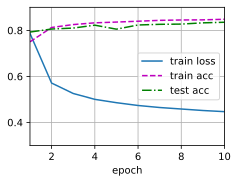

In [14]:
num_epochs = 10

def evaluate_accuracy(net, data_iter): #@save
    """计算在指定数据集上的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = d2l.Accumulator(2) # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_epoch_ch3(net, train_iter, loss, updater): #@save
    """训练模型一个迭代周期（定义见第3章)"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), d2l.accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): #@save
    """训练模型（定义见第3章）"""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc, ))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

和以前一样，这个算法使结果收敛到一个相当高的精度，而且这次的代码比之前更精简了。

## 小结

- 使用深度学习框架的高级API，我们可以更简洁地实现softmax回归。
- 从计算的角度来看，实现softmax回归比较复杂。在许多情况下，深度学习框架在这些著名的技巧之外采取了额外的预防措施，来确保数值的稳定性。这使我们避免了在实践中从零开始编写模型时可能遇到的陷阱。

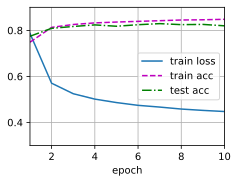

In [15]:
# 获取数据
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# 配置网络

# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

# 定义损失函数
loss = nn.CrossEntropyLoss(reduction='none')

# 定义训练器
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

# 训练
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 练习

1. 尝试调整超参数，例如批量大小、迭代周期数和学习率，并查看结果。

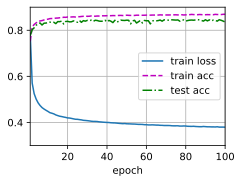

In [18]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

net = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights)

loss = torch.nn.CrossEntropyLoss(reduction='none')

trainer = torch.optim.SGD(net.parameters(), lr=0.1)

num_epochs = 100

train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

2. 增加迭代周期的数量。为什么测试精度会在一段时间后降低？我们怎么解决这个问题？

说明我们的模型过拟合了。

解决过拟合的方法：
- 增加训练集数据量
- 提前停止训练
- 进行Dropout正则化\噪声正则化\L1、L2正则化等
- 进行数据增强
- 减少网络宽度和深度